In [8]:
!pip install pytorch_tabnet

In [9]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

In [10]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [11]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

In [12]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])
train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)
test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)
train
test

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""00c0cd71""","""Winter""",7,0,"""Summer""",51,"""Spring""",29.315775,54.0,121.6,null,80,75,99,"""Spring""",4,5,32,"""Spring""",6,1,null,null,null,null,0,0,12.0,1,15.0,1,12.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",35,50,"""Winter""",2
"""00d56d4b""","""Spring""",5,1,"""Summer""",80,"""Spring""",17.284504,44.0,47.6,null,61,76,109,"""Spring""",null,null,null,"""Spring""",0,0,null,null,null,null,0,0,10.5,1,10.0,1,7.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",37,53,"""Spring""",0
"""00d9913d""","""Fall""",10,1,null,null,"""Fall""",19.893157,55.0,85.6,30.0,null,81,null,null,null,null,null,"""Fall""",5,0,null,null,null,null,0,0,0.0,0,0.0,0,9.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Fall""",1


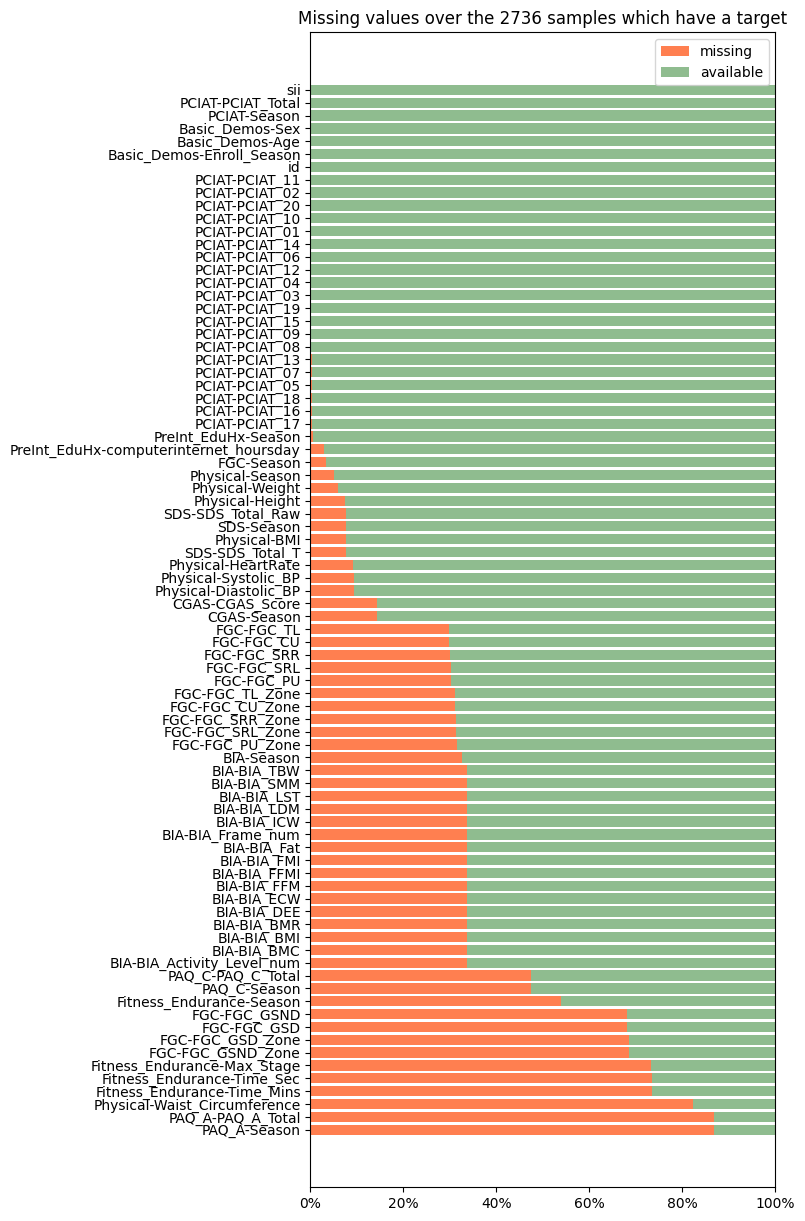

In [13]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)
missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)

plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

In [14]:
print(train.select(pl.col('PCIAT-PCIAT_Total').is_null() == pl.col('sii').is_null()).to_series().mean())
(train
 .select(pl.col('PCIAT-PCIAT_Total'))
 .group_by(train.get_column('sii'))
 .agg(pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT-PCIAT_Total min'),
      pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT-PCIAT_Total max'),
      pl.col('PCIAT-PCIAT_Total').len().alias('count'))
 .sort('sii')
)

1.0


sii,PCIAT-PCIAT_Total min,PCIAT-PCIAT_Total max,count
i64,i64,i64,u32
null,null,null,1224
0,0,30,1594
1,31,49,730
2,50,79,378
3,80,93,34


In [15]:
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


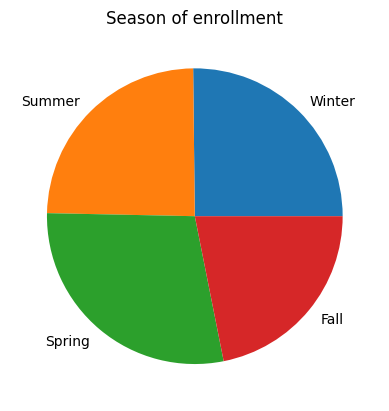

In [16]:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

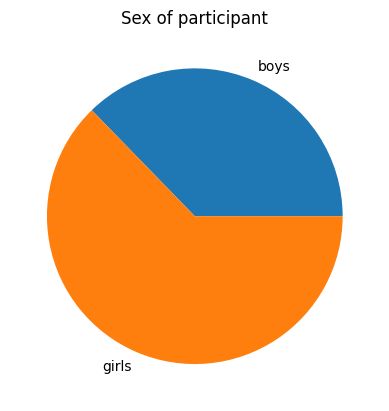

In [17]:
vc = train.get_column('Basic_Demos-Sex').value_counts()
plt.pie(vc.get_column('count'), labels=['boys', 'girls'])
plt.title('Sex of participant')
plt.show()


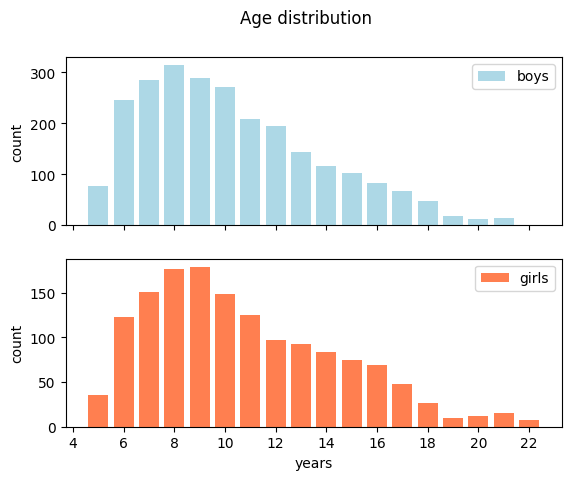

In [18]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

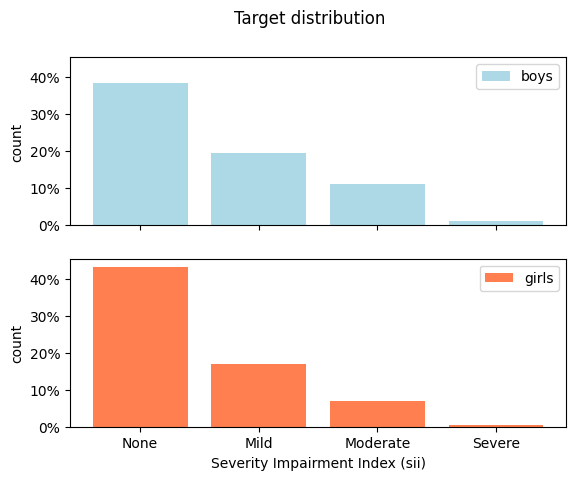

In [19]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
Physical-Waist_Circumference              0.327013
Physical-Systolic_BP                      0.147081
PreInt_EduHx-computerinternet_hoursday    0.374124
SDS-SDS_Total_T                           0.237718
FGC-FGC_CU                                0.287494
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_PU                                0.196006
FGC-FGC_TL                                0.136696
BIA-BIA_BMI                               0.248060
BIA-BIA_FFMI                              0.109694
BIA-BIA_Frame_num                         0.193631
Name: PCIAT-PCIAT_Total, dtype: float64


<Figure size 1400x1200 with 0 Axes>

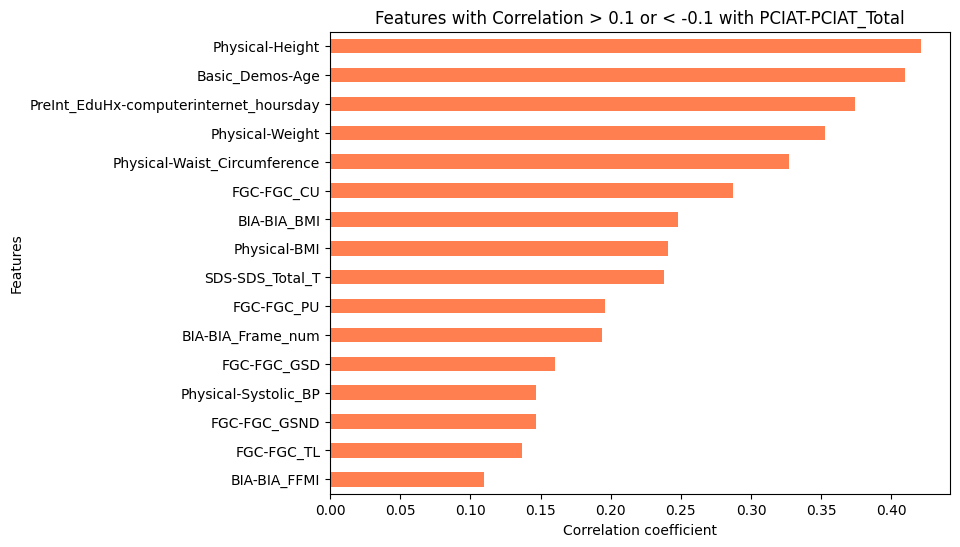

In [20]:
plt.figure(figsize=(14, 12))
corr_matrix = supervised_usable.select([
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL','BIA-BIA_Activity_Level_num', 
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI','BIA-BIA_FMI', 'BIA-BIA_Fat','BIA-BIA_Frame_num','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST',
    'BIA-BIA_SMM','BIA-BIA_TBW'
]).to_pandas().corr()
sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]
print(filtered_corr)
plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

In [21]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…
287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.0,3695.0,32875000000000,1,3,53.0
287175,-0.703572,0.016187,0.15956,0.03598,14.12139,0.0,7.0,3695.0,32880000000000,1,3,53.0
287176,-0.209607,-0.4697,0.636573,0.097799,44.998573,0.0,7.0,3695.0,32885000000000,1,3,53.0


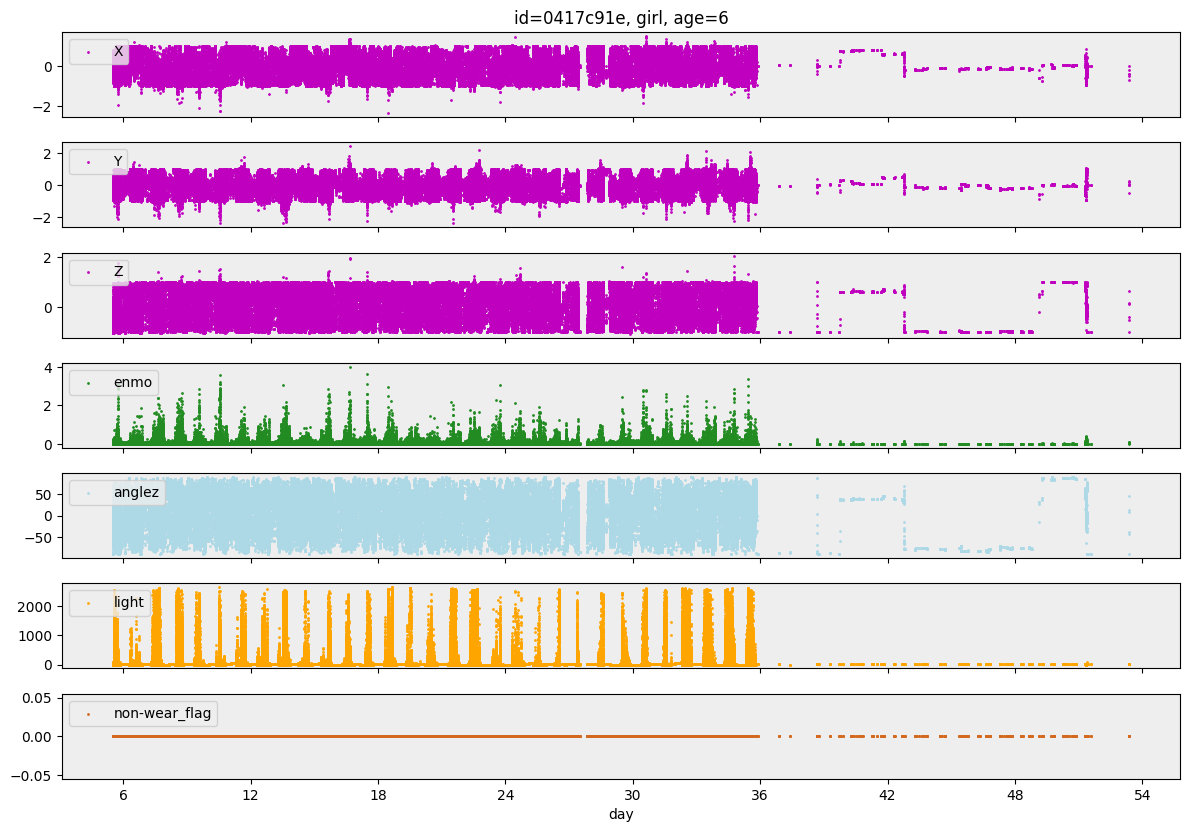

In [24]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)

    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()
analyze_actigraphy('0417c91e', only_one_week=False)

In [25]:
# Start by importing packages we'll need
import pandas as pd
import numpy as np
import os

In [26]:
import os
import pandas as pd

# Set the dataset location (update with your specific dataset path)
dataset_location = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/'

# Get a list of all the folders to make sure none of the names will be problematic
folders = os.listdir(dataset_location)

# Convert the list of folders into a DataFrame
folders_df = pd.DataFrame(folders, columns=['folder'])

# Save folders_df as a CSV file
folders_df.to_csv('folders.csv', index=False)


In [29]:
import os
import pandas as pd

# Specify dataset location (update this path if needed)
dataset_location = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/'

# Example subject id from your cleaned folder list (e.g., "0a418b57")
subject_id = "0a418b57"

# Build the file location using os.path.join
fileloc = os.path.join(dataset_location, 'id=' + str(subject_id), 'part-0.parquet')
print("Looking for file at:", fileloc)

# Check if the file exists
if os.path.exists(fileloc):
    data = pd.read_parquet(fileloc)
    print("File loaded successfully!")
else:
    print("File not found:", fileloc)


Looking for file at: /kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0a418b57/part-0.parquet
File loaded successfully!


In [30]:
import os
import pandas as pd
import numpy as np

# Specify dataset location (update this path if needed)
dataset_location = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/'

# Specify cutoffs

# ENMO cutoffs in mg for MVPA
mvpa_cutoff1 = 0.192
mvpa_cutoff2 = 0.110

# Number of 'active' bouts required for a day to count as 'active'
active_bout_cutoff = 150

# Specify the length of the bouts
boutlength = '5min'

# Maximum number of 5-minute bouts that can be imputed as zeroes to account for the accelerometer not collecting data when at rest
impute_max = 6

# Minimum number of 5-second intervals (within a 5-minute bout) that need to have data for the bout to be counted
impute_sec_min = 29

# Get a list of all folders in the dataset location
folders = os.listdir(dataset_location)

# Remove '.DS_Store' if present
folders = [folder for folder in folders if folder != '.DS_Store']

# Keep only items that start with the string 'id='
folders = [folder for folder in folders if folder[:3] == 'id=']

# Remove the first three characters ('id=') from each folder name
folders = [folder[3:] for folder in folders]

# Create a new DataFrame for the outputs
df = pd.DataFrame(columns=[
    'ID', 
    'ENMO_Avg_Active_Days_MVPA192', 
    'ENMO_Avg_Active_Days_MVPA110', 
    'Positive_Anglez_Active_Days'
])

df['ID'] = folders
df.set_index('ID', inplace=True)

# Iterate through each folder (subject)
for subject_id in folders:
    # Build the file location using os.path.join
    fileloc = os.path.join(dataset_location, 'id=' + str(subject_id), 'part-0.parquet')
    
    # Load the Parquet file
    data = pd.read_parquet(fileloc)

    # Remove rows where non-wear_flag is nonzero
    data = data[data['non-wear_flag'] == 0]

    # Convert time_of_day to datetime and create a modified datetime column
    data['dt'] = pd.to_datetime(data['time_of_day'])
    data['dt_mod'] = data['dt'] + pd.to_timedelta(data['relative_date_PCIAT'], unit='D')
    data.set_index('dt_mod', inplace=True)

    # Count the number of valid data points within each 5-minute interval
    data['count'] = 1
    number_of_data_points = data.resample(boutlength).agg({'count': 'sum'})
    data.drop('count', axis=1, inplace=True)

    # Create 5-minute bouts of averaged data and merge in the count of valid data points
    data_resampled_5min = data.resample(boutlength).mean()
    data_resampled_5min = data_resampled_5min.merge(number_of_data_points, left_index=True, right_index=True)

    # Identify sequences of NaN values for enmo and fill with 0 if the sequence is short enough (imputation)
    data_resampled_5min['enmogroup'] = data_resampled_5min['enmo'].notna().cumsum()
    enmogroupcount = data_resampled_5min.groupby('enmogroup').size().to_frame(name='enmogroupsize')
    data_resampled_5min = data_resampled_5min.merge(enmogroupcount, how='left', left_on='enmogroup', right_index=True)
    data_resampled_5min['smallinterval'] = (data_resampled_5min['enmogroupsize'] < impute_max + 2) & (data_resampled_5min['count'] > impute_sec_min)
    data_resampled_5min['filled_enmo'] = np.where(
        data_resampled_5min['smallinterval'], 
        data_resampled_5min['enmo'].fillna(0), 
        data_resampled_5min['enmo']
    )

    # Fill in anglez values only when count is large enough
    data_resampled_5min['filled_anglez'] = np.where(
        data_resampled_5min['count'] > impute_sec_min, 
        data_resampled_5min['anglez'], 
        np.nan
    )

    # Count the number of valid bouts in each day
    boutcount_filled = data_resampled_5min.groupby(data_resampled_5min.index.date).count()['filled_enmo'].to_frame()
    boutcount_filled = boutcount_filled.rename(columns={'filled_enmo': 'valid_bouts'})

    # Count bouts in each day with filled_enmo at least mvpa_cutoff1
    boutcount_MVPA1 = data_resampled_5min[data_resampled_5min['filled_enmo'] >= mvpa_cutoff1] \
                        .groupby(data_resampled_5min[data_resampled_5min['filled_enmo'] >= mvpa_cutoff1].index.date) \
                        .count()['filled_enmo'].to_frame()
    boutcount_MVPA1 = boutcount_MVPA1.rename(columns={'filled_enmo': 'MVPA_bouts_over_cutoff1'})
    
    # Merge MVPA1 counts with the valid bouts count
    boutcount = boutcount_filled.merge(boutcount_MVPA1, how='left', left_index=True, right_index=True)

    # Count bouts in each day with filled_enmo at least mvpa_cutoff2
    boutcount_MVPA2 = data_resampled_5min[data_resampled_5min['filled_enmo'] >= mvpa_cutoff2] \
                        .groupby(data_resampled_5min[data_resampled_5min['filled_enmo'] >= mvpa_cutoff2].index.date) \
                        .count()['filled_enmo'].to_frame()
    boutcount_MVPA2 = boutcount_MVPA2.rename(columns={'filled_enmo': 'MVPA_bouts_over_cutoff2'})
    boutcount = boutcount.merge(boutcount_MVPA2, how='left', left_index=True, right_index=True)

    # Count bouts in each day with filled_anglez greater than 0
    boutcount_anglez = data_resampled_5min[data_resampled_5min['filled_anglez'] > 0] \
                         .groupby(data_resampled_5min[data_resampled_5min['filled_anglez'] > 0].index.date) \
                         .count()['filled_anglez'].to_frame()
    boutcount_anglez = boutcount_anglez.rename(columns={'filled_anglez': 'Positive_Anglez_Bouts'})
    boutcount = boutcount.merge(boutcount_anglez, how='left', left_index=True, right_index=True)

    # Determine which days are "included" (active) based on the active_bout_cutoff
    boutcount['included_day'] = boutcount['valid_bouts'] >= active_bout_cutoff

    # Compute the mean of MVPA bouts for included days
    MVPA_mean1 = boutcount[boutcount['included_day'] == True]['MVPA_bouts_over_cutoff1'].mean()
    MVPA_mean2 = boutcount[boutcount['included_day'] == True]['MVPA_bouts_over_cutoff2'].mean()
    Anglez_mean1 = boutcount[boutcount['included_day'] == True]['Positive_Anglez_Bouts'].mean()

    # Store the computed averages into the DataFrame
    df.at[subject_id, 'ENMO_Avg_Active_Days_MVPA192'] = MVPA_mean1
    df.at[subject_id, 'ENMO_Avg_Active_Days_MVPA110'] = MVPA_mean2
    df.at[subject_id, 'Positive_Anglez_Active_Days'] = Anglez_mean1

# Replace any remaining NaN values with 0 (after processing all subjects)
df.fillna(0, inplace=True)

# Export the final DataFrame to a CSV file
df.to_csv('Accelerometer_enmo_anglez_daily_averages.csv')


In [33]:
#This is the starting data.
train=pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')

In [34]:
# Load the accelerometer data set Accelerometer_enmo_anglez_daily_averages.csv
accel = pd.read_csv('Accelerometer_enmo_anglez_daily_averages.csv')

# Join train and accel  on the 'id' column and accel on the 'ID' column
train = train.join(accel.set_index('ID'), on='id', how='left')

# It seems unlikly that we're going to want the ENMO_Avg_All_Days_MVPA192 or ENMO_Avg_All_Days_MVPA110 or Positive_Anglez_All_Days variables, so remove them
# Note: These variables no longer get generated from the Acclerometer_Computations, so we shouldn't need to remove them
#train = train.drop(columns=['ENMO_Avg_All_Days_MVPA192', 'ENMO_Avg_All_Days_MVPA110', 'Positive_Anglez_All_Days']) 

In [35]:
# Create a new variable 'FGC-FGC_SR' that is the mean of FGC-FGC_SRL and FGC-FGC_SRR
train['FGC-FGC_SR'] = train[['FGC-FGC_SRL', 'FGC-FGC_SRR']].mean(axis=1)

# Remove the old sit & reach variables
train = train.drop(columns=['FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone'])

In [36]:
def sitreachzone(sex, age, sr):
    try:
        if np.isnan(sr):
            return np.nan
        elif sex == 0 and sr>=8:
            return 1
        elif sex == 1 and age >= 15 and sr >= 12:
            return 1
        elif sex == 1 and age >= 11 and sr >= 10:
            return 1
        elif sex == 1 and age >= 5 and sr >= 9:
            return 1
        else:
            return 0
    except:
        return np.nan

# Apply sitreachzone to create a new column using the columns Basic_Demos-Sex, Basic_Demos-Age, and FGC-FGC_SR as inputs
train['FGC-FGC_SR_Zone'] = train.apply(lambda x: sitreachzone(x['Basic_Demos-Sex'], x['Basic_Demos-Age'], x['FGC-FGC_SR']), axis=1)


In [37]:
# Create a new variable that is 1 when PAQA/C Total is at least 2.75/2.73, 0 if it's less than these cutoffs, and NaN if PAQA/C is NaN
train['PAQA_Zone'] = np.where(train['PAQ_A-PAQ_A_Total']>=2.75, 1, 0)
train['PAQA_Zone'] = np.where(train['PAQ_A-PAQ_A_Total'].isnull(), np.nan, train['PAQA_Zone'])

train['PAQC_Zone'] = np.where(train['PAQ_C-PAQ_C_Total']>=2.73, 1, 0)
train['PAQC_Zone'] = np.where(train['PAQ_C-PAQ_C_Total'].isnull(), np.nan, train['PAQC_Zone'])

In [38]:
# Create new variables that merge the three PAQA/C variables
train['PAQ_Total']=train['PAQ_C-PAQ_C_Total']
train.loc[train['PAQ_Total'].isnull(),'PAQ_Total']=train['PAQ_A-PAQ_A_Total']

train['PAQ_Season']=train['PAQ_C-Season']
train.loc[train['PAQ_Season'].isnull(),'PAQ_Season']=train['PAQ_A-Season']

train['PAQ_Zone']=train['PAQC_Zone']
train.loc[train['PAQ_Zone'].isnull(),'PAQ_Zone']=train['PAQA_Zone']

# Drop the PAQ variables we no longer need
train=train.drop(columns=['PAQ_C-PAQ_C_Total', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_A-Season', 'PAQA_Zone', 'PAQC_Zone'])

In [39]:
# Combine the minutes and seconds of Fitness_Endurance into a single number (total number of seconds)
train['Fitness_Endurance_Total_Time_Sec'] = train['Fitness_Endurance-Time_Mins'] * 60 + train['Fitness_Endurance-Time_Sec']

train=train.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'])

In [40]:
# Remove the SDS-SDS_Total_T variable from train
train=train.drop(columns=['SDS-SDS_Total_T'])

In [41]:
train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,ENMO_Avg_Active_Days_MVPA192,ENMO_Avg_Active_Days_MVPA110,Positive_Anglez_Active_Days,FGC-FGC_SR,FGC-FGC_SR_Zone,PAQ_Total,PAQ_Season,PAQ_Zone,Fitness_Endurance_Total_Time_Sec
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,6.5,0.0,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,Summer,0.0,0.0,NaN,NaN,NaN,11.0,1.0,2.340,Fall,0.0,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,Summer,2.0,0.0,NaN,NaN,NaN,10.0,1.0,2.170,Summer,0.0,453.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,Winter,0.0,1.0,9.0,24.0,39.0,7.0,0.0,2.451,Winter,0.0,577.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.040,Summer,0.0,NaN


In [42]:
# Remove the FGC-FGC_GSND, FGC-FGC_GSND_Zone, FGC-FGC_GSD, and FGC-FGC_GSD_Zone variables
train=train.drop(columns=['FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone'])

In [43]:
# Create a list of numerical columns of type float. Note that these columns include the "Zone" variables which are really categorical/ordinal:
float_columns = train.select_dtypes(include=['float']).columns

# Change negative values to NaN
train[train[float_columns] < 0] = np.nan

In [44]:
# For each variable that starts with 'Physical-' replace any values that are 0 with NaN
for column in train.columns:
    if column.startswith('Physical-'):
        train[column] = train[column].replace(0, np.nan)

In [45]:
# For each column in float_columns, identify entries that are 5 standard deviations above or below the mean and replace them with NaN
for column in float_columns:
    train[column] = train[column].mask(train[column] > train[column].mean() + 5 * train[column].std())
    train[column] = train[column].mask(train[column] < train[column].mean() - 5 * train[column].std())

In [46]:
#The original competition data has been named train_original
#Here I am splitting the data into a train and test set. I want to stratify by age. 
# Then I export as csv files, since we are working over multiple jupiter notebooks.

from sklearn.model_selection import train_test_split


seed=1275
train_cleaned, test_cleaned = train_test_split(train, test_size=0.2, random_state=seed, stratify=train['Basic_Demos-Age'])

train_cleaned.to_csv('train_cleaned.csv', index=False)
test_cleaned.to_csv('test_cleaned.csv',index=False)

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
# Load the original data set
train_cleaned = pd.read_csv('/kaggle/working/train_cleaned.csv')

In [81]:
# Make a list of numeric features
numeric_features = train_cleaned.select_dtypes(include=[np.number]).columns

# Remove all PCIAT variables from numeric features
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT').columns))

# Remove sii from numeric_features
numeric_features = numeric_features.drop(['sii'])

In [82]:
# Compute absolute values of correlations between each predictor in numeric_features and PCIAT-PCIAT_Total
correlations = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['PCIAT-PCIAT_Total'])))

# Order correlations from largest to smallest
correlations = correlations.sort_values(ascending=False)

correlations.head(10)

Physical-Height                           0.418307
Basic_Demos-Age                           0.413493
PreInt_EduHx-computerinternet_hoursday    0.379375
Physical-Weight                           0.366156
BIA-BIA_FFM                               0.330358
BIA-BIA_BMR                               0.330358
BIA-BIA_LDM                               0.328595
BIA-BIA_LST                               0.328057
BIA-BIA_TBW                               0.324602
BIA-BIA_ECW                               0.323074
dtype: float64

In [83]:
# Create a new variable that is log(PCIAT-PCIAT_Total)
train_cleaned['log_PCIAT-PCIAT_Total'] = np.log(train_cleaned['PCIAT-PCIAT_Total'])

# Replace -inf values in log_PCIAT-PCIAT_Total with -1
train_cleaned['log_PCIAT-PCIAT_Total'] = train_cleaned['log_PCIAT-PCIAT_Total'].replace(-np.inf, -1)

# Compute absolute values of correlations between each predictor in numeric_features and log_PCIAT-PCIAT_Total
correlations_log = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['log_PCIAT-PCIAT_Total'])))
correlations_log = correlations_log.sort_values(ascending=False)

correlations_log.head(10)

Physical-Height                           0.371769
Basic_Demos-Age                           0.361570
PreInt_EduHx-computerinternet_hoursday    0.313368
Physical-Weight                           0.307315
FGC-FGC_CU                                0.274658
BIA-BIA_LDM                               0.269355
BIA-BIA_FFM                               0.267440
BIA-BIA_BMR                               0.267440
Physical-Waist_Circumference              0.266843
BIA-BIA_LST                               0.265613
dtype: float64

In [84]:
# Create a new variable that is (PCIAT-PCIAT_Total)^2
train_cleaned['squared_PCIAT-PCIAT_Total'] = train_cleaned['PCIAT-PCIAT_Total']**2

# Compute absolute values of correlations between each predictor in numeric_features and squared_PCIAT-PCIAT_Total
correlations_squared = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['squared_PCIAT-PCIAT_Total'])))
correlations_squared = correlations_squared.sort_values(ascending=False)
correlations_squared.head(10)

Basic_Demos-Age                           0.380519
Physical-Height                           0.377620
PreInt_EduHx-computerinternet_hoursday    0.349693
Physical-Weight                           0.347817
BIA-BIA_BMR                               0.314501
BIA-BIA_FFM                               0.314501
BIA-BIA_LDM                               0.312210
BIA-BIA_LST                               0.311001
BIA-BIA_TBW                               0.309245
BIA-BIA_ECW                               0.305664
dtype: float64

In [85]:
# Remove the log_PCIAT-PCIAT_Total and squared_PCIAT-PCIAT_Total variables
train_cleaned = train_cleaned.drop(['log_PCIAT-PCIAT_Total', 'squared_PCIAT-PCIAT_Total'], axis=1)

In [86]:
print(train_cleaned.shape)

(3168, 76)


In [87]:
#Create an initial list of predictor columns

predictors = train_cleaned.columns.tolist()
if 'id' in predictors:
    predictors.remove('id')
if 'sii' in predictors:
    predictors.remove('sii')
predictors = [x for x in predictors if 'PCIAT' not in x]
predictors = [x for x in predictors if 'Season' not in x]

In [88]:
print("Shape of predictors data:", train_cleaned[predictors].shape)
print("Shape of target:", train_cleaned['PCIAT-PCIAT_Total'].shape)


Shape of predictors data: (3168, 43)
Shape of target: (3168,)


In [89]:
# Drop rows with missing target or predictors
train_cleaned = train_cleaned.dropna(subset=['PCIAT-PCIAT_Total'])

pipe_mice.fit(train_cleaned[predictors], train_cleaned['PCIAT-PCIAT_Total'])
train_pred_mice = pipe_mice.predict(train_cleaned[predictors])


In [90]:
import sys
sys.path.insert(0, '/kaggle/input/custom/keras/default/1')

import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from CustomImputers import *  # Now imports from the file in your specified location

# (Assuming that train_cleaned and predictors are defined somewhere in your notebook)

pipe_mice = Pipeline([
    ('mice_impute', Custom_MICE_Imputer()),
    ('add_zones', FunctionTransformer(zone_encoder)),
    ('rf', RandomForestRegressor(n_estimators=300, max_features='sqrt', max_depth=5, random_state=216))
])

pipe_mice.fit(train_cleaned[predictors], train_cleaned['PCIAT-PCIAT_Total'])
train_pred_mice = pipe_mice.predict(train_cleaned[predictors])

# Get feature importance from the RF inside the pipeline
score_mice_df = pd.DataFrame({
    'feature': train_cleaned[predictors].columns,
    'importance_score': pipe_mice.named_steps['rf'].feature_importances_
})

score_mice_df.sort_values('importance_score', ascending=False)


,feature,importance_score
34,PreInt_EduHx-computerinternet_hoursday,0.125700
0,Basic_Demos-Age,0.112208
4,Physical-Height,0.091767
33,SDS-SDS_Total_Raw,0.064260
5,Physical-Weight,0.063273
30,BIA-BIA_LST,0.054930
11,FGC-FGC_CU,0.048570
36,ENMO_Avg_Active_Days_MVPA110,0.046509
20,BIA-BIA_BMR,0.034362
23,BIA-BIA_FFM,0.026331


In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from scipy import stats
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import warnings
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pickle

warnings.filterwarnings('ignore')

In [2]:
SEED = 9365
n_splits = 10
optimize_params = False
n_trials = 25 # n_trials for optuna 
voting = True
base_thresholds = [30, 50, 80]

In [3]:
# Load datasets
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [4]:
def perform_pca(train, test, n_components=None, random_state=42):
    
    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

In [5]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(),
    ]
    
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    no_mask = np.ones(len(df), dtype=bool)
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.diff().mean(), 
            data.diff().std()
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

# Code for parallelized computation of time series data from: Sheikh Muhammad Abdullah 
# https://www.kaggle.com/code/abdmental01/cmi-best-single-model
def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [6]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    
    # From here on own features
    def assign_group(age):
        thresholds = [5, 6, 7, 8, 10, 12, 14, 17, 22]
        for i, j in enumerate(thresholds):
            if age <= j:
                return i
        return np.nan
    
    # Age groups
    df["group"] = df['Basic_Demos-Age'].apply(assign_group)
    
    # BMI 
    BMI_map = {0: 16.3,1: 15.9,2: 16.1,3: 16.8,4: 17.3,5: 19.2,6: 20.2,7: 22.3, 8: 23.6}
    df['BMI_mean_norm'] = df[['Physical-BMI', 'BIA-BIA_BMI']].mean(axis=1) / df["group"].map(BMI_map)
    
    # FGC zone aggregate
    zones = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
             'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
             'FGC-FGC_TL_Zone']
    
    df['FGC_Zones_mean'] = df[zones].mean(axis=1)
    df['FGC_Zones_min'] = df[zones].min(axis=1)
    df['FGC_Zones_max'] = df[zones].max(axis=1)
    
    # Grip
    GSD_max_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 16.2, 5: 19.9, 6: 26.1, 7: 31.3, 8: 35.4}
    GSD_min_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 14.4, 5: 17.8, 6: 23.4, 7: 27.8, 8: 31.1}
    
    df['GS_max'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].max(axis=1) / df["group"].map(GSD_max_map)
    df['GS_min'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].min(axis=1) / df["group"].map(GSD_min_map)
    
    # Curl-ups, push-ups, trunk-lifts... normalized based on age-group
    cu_map = {0: 1.0, 1: 3.0, 2: 5.0, 3: 7.0, 4: 10.0, 5: 14.0, 6: 20.0, 7: 20.0, 8: 20.0}
    pu_map = {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0, 6: 8.0, 7: 10.0, 8: 14.0}
    tl_map = {0: 8.0, 1: 8.0, 2: 8.0, 3: 9.0, 4: 9.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0}
    
    df["CU_norm"] = df['FGC-FGC_CU'] / df['group'].map(cu_map)
    df["PU_norm"] = df['FGC-FGC_PU'] / df['group'].map(pu_map)
    df["TL_norm"] = df['FGC-FGC_TL'] / df['group'].map(tl_map)
    
    # Reach 
    df["SR_min"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].min(axis=1)
    df["SR_max"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].max(axis=1)

    # BIA Features
    # Energy Expenditure
    bmr_map = {0: 934.0, 1: 941.0, 2: 999.0, 3: 1048.0, 4: 1283.0, 5: 1255.0, 6: 1481.0, 7: 1519.0, 8: 1650.0}
    dee_map = {0: 1471.0, 1: 1508.0, 2: 1640.0, 3: 1735.0, 4: 2132.0, 5: 2121.0, 6: 2528.0, 7: 2566.0, 8: 2793.0}
    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["group"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["group"].map(dee_map)
    df["DEE_BMR"] = df["BIA-BIA_DEE"] - df["BIA-BIA_BMR"]

    # FMM
    ffm_map = {0: 42.0, 1: 43.0, 2: 49.0, 3: 54.0, 4: 60.0, 5: 76.0, 6: 94.0, 7: 104.0, 8: 111.0}
    df["FFM_norm"] = df["BIA-BIA_FFM"] / df["group"].map(ffm_map)

    # ECW ICW
    df["ICW_ECW"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]
    
    drop_feats = ['FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
                  'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
                  'Physical-BMI', 'BIA-BIA_BMI', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'FGC-FGC_SRL', 'FGC-FGC_SRR',
                 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_Frame_num', "BIA-BIA_FFM"]
    df = df.drop(drop_feats, axis=1) 
    return df

In [7]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

scaler = StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

for c in df_train.columns:
    m = np.mean(df_train[c])
    df_train[c].fillna(m, inplace=True)
    df_test[c].fillna(m, inplace=True)

print(df_train.shape)

df_train_pca, df_test_pca, pca = perform_pca(df_train, df_test, n_components=15, random_state=SEED)

df_train_pca['id'] = train_ts['id']
df_test_pca['id'] = test_ts['id']

train = pd.merge(train, df_train_pca, how="left", on='id')
test = pd.merge(test, df_test_pca, how="left", on='id')
train.shape

100%|██████████| 2/2 [00:00<00:00, 12.09it/s]


(996, 74)
Explained variance ratio of the components:
 [0.22219101 0.11409028 0.0661572  0.06115724 0.05273775 0.04588977
 0.04282018 0.03804032 0.03464054 0.02994127 0.0258286  0.02512189
 0.02316014 0.02173831 0.01984057]
0.8233550636748745


(3960, 97)

In [ ]:
def clean_features(df):
    # Remove highly implausible values

    # Clip Grip
    df[['FGC-FGC_GSND', 'FGC-FGC_GSD']] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].clip(lower=9, upper=60)
    # Remove implausible body-fat
    df["BIA-BIA_Fat"] = np.where(df["BIA-BIA_Fat"] < 5, np.nan, df["BIA-BIA_Fat"])
    df["BIA-BIA_Fat"] = np.where(df["BIA-BIA_Fat"] > 60, np.nan, df["BIA-BIA_Fat"])
    # Basal Metabolic Rate
    df["BIA-BIA_BMR"] = np.where(df["BIA-BIA_BMR"] > 4000, np.nan, df["BIA-BIA_BMR"])
    # Daily Energy Expenditure
    df["BIA-BIA_DEE"] = np.where(df["BIA-BIA_DEE"] > 8000, np.nan, df["BIA-BIA_DEE"])
    # Bone Mineral Content
    df["BIA-BIA_BMC"] = np.where(df["BIA-BIA_BMC"] <= 0, np.nan, df["BIA-BIA_BMC"])
    df["BIA-BIA_BMC"] = np.where(df["BIA-BIA_BMC"] > 10, np.nan, df["BIA-BIA_BMC"])
    # Fat Free Mass Index
    df["BIA-BIA_FFM"] = np.where(df["BIA-BIA_FFM"] <= 0, np.nan, df["BIA-BIA_FFM"])
    df["BIA-BIA_FFM"] = np.where(df["BIA-BIA_FFM"] > 300, np.nan, df["BIA-BIA_FFM"])
    # Fat Mass Index
    df["BIA-BIA_FMI"] = np.where(df["BIA-BIA_FMI"] < 0, np.nan, df["BIA-BIA_FMI"])
    # Extra Cellular Water
    df["BIA-BIA_ECW"] = np.where(df["BIA-BIA_ECW"] > 100, np.nan, df["BIA-BIA_ECW"])
    # Intra Cellular Water
    # df["BIA-BIA_ICW"] = np.where(df["BIA-BIA_ICW"] > 100, np.nan, df["BIA-BIA_ICW"])
    # Lean Dry Mass
    df["BIA-BIA_LDM"] = np.where(df["BIA-BIA_LDM"] > 100, np.nan, df["BIA-BIA_LDM"])
    # Lean Soft Tissue
    df["BIA-BIA_LST"] = np.where(df["BIA-BIA_LST"] > 300, np.nan, df["BIA-BIA_LST"])
    # Skeletal Muscle Mass
    df["BIA-BIA_SMM"] = np.where(df["BIA-BIA_SMM"] > 300, np.nan, df["BIA-BIA_SMM"])
    # Total Body Water
    df["BIA-BIA_TBW"] = np.where(df["BIA-BIA_TBW"] > 300, np.nan, df["BIA-BIA_TBW"])
    
    return df

train = clean_features(train)
test = clean_features(test)

In [8]:
train = feature_engineering(train)
test = feature_engineering(test)

In [9]:
def bin_data(train, test, columns, n_bins=10):
    # Combine train and test for consistent bin edges
    combined = pd.concat([train, test], axis=0)
    
    bin_edges = {}
    for col in columns:
        # Compute quantile bin edges
        edges = pd.qcut(combined[col], n_bins, retbins=True, labels=range(n_bins), duplicates="drop")[1]
        bin_edges[col] = edges
    
    # Apply the same bin edges to both train and test
    for col, edges in bin_edges.items():
        train[col] = pd.cut(
            train[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)
        test[col] = pd.cut(
            test[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)
    
    return train, test

# Usage example
columns_to_bin = [
    "PAQ_A-PAQ_A_Total", "BMR_norm", "DEE_norm", "GS_min", "GS_max", "BIA-BIA_FFMI", 
    "BIA-BIA_BMC", "Physical-HeartRate", "BIA-BIA_ICW", "Fitness_Endurance-Time_Sec", 
    "BIA-BIA_LDM", "BIA-BIA_SMM", "BIA-BIA_TBW", "DEE_BMR", "ICW_ECW"
]
train, test = bin_data(train, test, columns_to_bin, n_bins=10)

In [10]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition
features = [f for f in train.columns if f not in exclude]

# Categorical features
# cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
#           'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
cat_c = []

for col in cat_c:
    a_map = {}
    all_unique = set(train[col].unique()) | set(test[col].unique())
    for i, value in enumerate(all_unique):
        a_map[value] = i

    train[col] = train[col].map(a_map)
    test[col] = test[col].map(a_map)
    
train = train[train["sii"].notna()] # Keep rows where target is available
train.shape

(2736, 83)

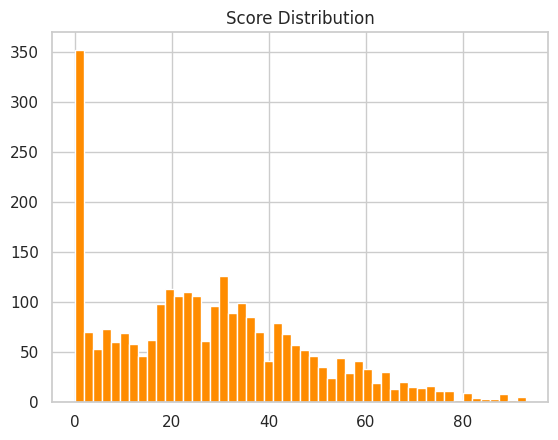

In [11]:
# Plot distribution of total scores which determine the sii
# Note the excess zeros -> consider other objective functions
sns.set_theme(style="whitegrid")
plt.hist(train['PCIAT-PCIAT_Total'], bins=50, color="darkorange")
plt.title('Score Distribution')
plt.show()

In [12]:
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [13]:
missing = pd.DataFrame(train.isna().sum() / len(train))
missing[missing[0] > 0.3][:60]

,0
Physical-Waist_Circumference,0.823465
Fitness_Endurance-Max_Stage,0.732822
Fitness_Endurance-Time_Mins,0.733918
Fitness_Endurance-Time_Sec,0.733918
BIA-BIA_Activity_Level_num,0.337354
BIA-BIA_BMC,0.337354
BIA-BIA_ECW,0.337354
BIA-BIA_FFMI,0.337354
BIA-BIA_FMI,0.337354
BIA-BIA_Fat,0.337354


In [14]:
model = LassoCV(cv=5, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer.fit_models(model, train, features)
train = imputer.impute(train)
test = imputer.impute(test)

100%|██████████| 60/60 [00:08<00:00,  7.06it/s]


In [15]:
# Code for finding optimal thresholds copied from: Michael Semenoff
# https://www.kaggle.com/code/michaelsemenoff/cmi-actigraphy-feature-engineering-selection
def round_with_thresholds(raw_preds, thresholds):
    return np.where(raw_preds < thresholds[0], int(0),
                    np.where(raw_preds < thresholds[1], int(1),
                             np.where(raw_preds < thresholds[2], int(2), int(3))))

def optimize_thresholds(y_true, raw_preds, start_vals=[0.5, 1.5, 2.5]):
    def fun(thresholds, y_true, raw_preds):
        rounded_preds = round_with_thresholds(raw_preds, thresholds)
        return -cohen_kappa_score(y_true, rounded_preds, weights='quadratic')

    res = minimize(fun, x0=start_vals, args=(y_true, raw_preds), method='Powell')
    assert res.success
    return res.x

In [16]:
def calculate_weights(series):
    # Create bins for the target variable and assign weights based on frequency
    bins = pd.cut(series, bins=10, labels=False)
    weights = bins.value_counts().reset_index()
    weights.columns = ['target_bins', 'count']
    weights['count'] = 1 / weights['count']
    weight_map = weights.set_index('target_bins')['count'].to_dict()
    weights = bins.map(weight_map)
    return weights / weights.mean() 

In [17]:
def cross_validate(model_, data, features, score_col, index_col, cv, sample_weights=False, verbose=False):
    """
    Perform cross-validation with a given model and compute the out-of-fold 
    predictions and Cohen's Kappa score for each fold.

    Returns:
    float: Mean Kappa score across all folds.
    array: Out-of-fold score predictions for the entire dataset.
    """
    kappa_scores = [] 
    oof_score_predictions = np.zeros(len(data))  

    score_to_index_thresholds = base_thresholds  
    thresholds = []
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(data, data[index_col])):
        X_train, X_val = data[features].iloc[train_idx], data[features].iloc[val_idx]
        y_train_score = data[score_col].iloc[train_idx] 
        y_train_index = data[index_col].iloc[train_idx]
        y_val_score = data[score_col].iloc[val_idx]      
        y_val_index = data[index_col].iloc[val_idx]     
        
        # Train model with sample weights if provided
        if sample_weights:
            weights = calculate_weights(y_train_score)
            model_.fit(X_train, y_train_score, sample_weight=weights)
        else:
            model_.fit(X_train, y_train_score)

        y_pred_train_score = model_.predict(X_train)
        y_pred_val_score = model_.predict(X_val)
        
        oof_score_predictions[val_idx] = y_pred_val_score 

        # Find optimal threshold in sample 
        t_1 = optimize_thresholds(y_train_index, y_pred_train_score, start_vals=base_thresholds)
        thresholds.append(t_1)

        y_pred_val_index = round_with_thresholds(y_pred_val_score, t_1)

        kappa_score = cohen_kappa_score(y_val_index, y_pred_val_index, weights='quadratic')
        kappa_scores.append(kappa_score)
        
        if verbose:
            print(f"Fold {fold_idx}: Optimized Kappa Score = {kappa_score}")
    
    if verbose:
        print(f"## Mean CV Kappa Score: {np.mean(kappa_scores)} ##")
        print(f"## Std CV: {np.std(kappa_scores)}")
    
    return np.mean(kappa_scores), oof_score_predictions, thresholds

def n_cross_validate(model_, data, features, score_col, index_col, cv, seeds, sample_weights=False, verbose=False):
    scores = []
    for seed in seeds:
        cv.random_state=seed
        score, oof, _ = cross_validate(model_, data, features, score_col, index_col, cv, sample_weights=True, verbose=False)
        scores.append(score)
    return score, oof

In [18]:
def objective(trial, model_type, X, features, score_col, index_col, cv, sample_weights=False):
    # Parameter space to explore if model is xgboost
    if model_type == 'xgboost':
        params = {
            'objective': trial.suggest_categorical('objective', ['reg:tweedie', 'reg:pseudohubererror']),
            'random_state': SEED,
            'num_parallel_tree': trial.suggest_int('num_parallel_tree', 2, 30),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 2, 4),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.05),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e-1),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e-1),
        }
        if params['objective'] == 'reg:tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = XGBRegressor(**params, use_label_encoder=False)
    
    # Parameter space to explore if model is lightgbm
    elif model_type == 'lightgbm':
        params = {
            'objective': trial.suggest_categorical('objective', ['poisson', 'tweedie', 'regression']),
            'random_state': SEED,
            'verbosity': -1,
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 2, 4),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100)
        }
        if params['objective'] == 'tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = LGBMRegressor(**params)
    
    # Parameter space to explore if model is catboost
    elif model_type == 'catboost':
        params = {
            'loss_function': trial.suggest_categorical('objective', ['Tweedie:variance_power=1.5', 
                                                                     'Poisson', 'RMSE']),
            'random_state': SEED,
            'iterations': trial.suggest_int('iterations', 100, 300),
            'depth': trial.suggest_int('depth', 2, 4),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1e-1),
            'subsample': trial.suggest_float('subsample', 0.5, 0.7),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 60),
        }
        model = CatBoostRegressor(**params, verbose=0)
    
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")
        
    seeds = [random.randint(1, 10000) for _ in range(20)]

    score, _ = n_cross_validate(model, X, features, score_col, index_col, cv, seeds, sample_weights=True, verbose=True)

    return score

def run_optimization(X, features, score_col, index_col, model_type, n_trials=30, cv=None, sample_weights=False):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_type, X, features, score_col, index_col, cv, sample_weights), 
                   n_trials=n_trials)
    
    print(f"Best params for {model_type}: {study.best_params}")
    print(f"Best score: {study.best_value}")
    return study.best_params

In [19]:
# Replace if subsets for features have been selected

exclude = ["PC_9", "PC_12", "Fitness_Endurance-Max_Stage", "Basic_Demos-Sex", 'BMI_mean_norm', "PC_11", "PC_8", "FGC_Zones_min", 'Physical-Systolic_BP',
           "PC_4", "BIA-BIA_FMI", "BIA-BIA_LST", "Physical-Diastolic_BP", 'BIA-BIA_ECW', 'Fitness_Endurance-Time_Mins', 'PAQ_C-PAQ_C_Total', 'PC_10',
           'BIA-BIA_Fat', 'FFM_norm', 'PC_14', 'PC_7']

reduced_features = [f for f in features if f not in exclude]

lgb_features = reduced_features
xgb_features = reduced_features
cat_features = reduced_features
print(len(reduced_features))

39


In [20]:
# Parameters for LGBM, XGB and CatBoost
lgb_params = {
    'objective': 'poisson', 
    'n_estimators': 295, 
    'max_depth': 4, 
    'learning_rate': 0.04505693066482616, 
    'subsample': 0.6042489155604022, 
    'colsample_bytree': 0.5021876720502726, 
    'min_data_in_leaf': 100
}

xgb_params = {'objective': 'reg:tweedie', 'num_parallel_tree': 12, 'n_estimators': 236, 'max_depth': 3, 'learning_rate': 0.04223740904479563, 'subsample': 0.7157264603586825, 'colsample_bytree': 0.7897918901977528, 'reg_alpha': 0.005335705058190553, 'reg_lambda': 0.0001897435318347022, 'tweedie_variance_power': 1.1393958601390142}

xgb_params_2 = {
    'objective': 'reg:tweedie', 
    'num_parallel_tree': 18, 
    'n_estimators': 175, 
    'max_depth': 3, 
    'learning_rate': 0.032620453423049305, 
    'subsample': 0.6155579670568023, 
    'colsample_bytree': 0.5988773292417443, 
    'reg_alpha': 0.0028895066837627205, 
    'reg_lambda': 0.002232531512636924, 
    'tweedie_variance_power': 1.1708678482038286
}

cat_params = {
    'objective': 'RMSE', 
    'iterations': 238, 
    'depth': 4, 
    'learning_rate': 0.044523361750173816, 
    'l2_leaf_reg': 0.09301285673435761, 
    'subsample': 0.6902492783438681, 
    'bagging_temperature': 0.3007304771330199, 
    'random_strength': 3.562201626987314, 
    'min_data_in_leaf': 60
}

xtrees_params = {
    'n_estimators': 500, 
    'max_depth': 15, 
    'min_samples_leaf': 20, 
    'bootstrap': False
}

In [21]:
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

In [22]:
if optimize_params:
    # LightGBM Optimization
    lgb_params = run_optimization(train, lgb_features, 'PCIAT-PCIAT_Total', 'sii', 'lightgbm', n_trials=n_trials, cv=kf, sample_weights=True)

    # XGBoost Optimization
    xgb_params = run_optimization(train, xgb_features, 'PCIAT-PCIAT_Total', 'sii', 'xgboost', n_trials=n_trials, cv=kf, sample_weights=True)

    # CatBoost Optimization
    cat_params = run_optimization(train, cat_features, 'PCIAT-PCIAT_Total', 'sii', 'catboost', n_trials=n_trials, cv=kf, sample_weights=True)

In [23]:
# Define models
lgb_model = LGBMRegressor(**lgb_params, random_state=SEED, verbosity=-1)
xgb_model = XGBRegressor(**xgb_params, random_state=SEED, verbosity=0)
xgb_model_2 = XGBRegressor(**xgb_params_2, random_state=SEED, verbosity=0)
cat_model = CatBoostRegressor(**cat_params, random_state=SEED, verbose=0)
xtrees_model = ExtraTreesRegressor(**xtrees_params, random_state=SEED)

weights = calculate_weights(train['PCIAT-PCIAT_Total'])

# Cross-validate LGBM model
score_lgb, oof_lgb, lgb_thresholds = cross_validate(
    lgb_model, train, lgb_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
lgb_model.fit(train[lgb_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_lgb = lgb_model.predict(test[lgb_features])

# Cross-validate XGBoost model
score_xgb, oof_xgb, xgb_thresholds = cross_validate(
    xgb_model, train, xgb_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
xgb_model.fit(train[xgb_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_xgb = xgb_model.predict(test[xgb_features])

# Cross-validate XGBoost model 2
score_xgb_2, oof_xgb_2, xgb_2_thresholds = cross_validate(
    xgb_model_2, train, xgb_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
xgb_model_2.fit(train[xgb_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_xgb_2 = xgb_model_2.predict(test[xgb_features])

# Cross-validate CatBoost model
score_cat, oof_cat, cat_thresholds = cross_validate(
    cat_model, train, cat_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
cat_model.fit(train[cat_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_cat = cat_model.predict(test[cat_features])

# Cross-validate ExtraTreesRegressor model
score_xtrees, oof_xtrees, xtrees_thresholds = cross_validate(
    xtrees_model, train, reduced_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True, sample_weights=True
)
xtrees_model.fit(train[reduced_features], train['PCIAT-PCIAT_Total'], sample_weight=weights)
test_xtrees = xtrees_model.predict(test[reduced_features])

# Print overall mean Kappa score for all models
print(f'Overall Mean Kappa: {np.mean([score_lgb, score_xgb, score_cat, score_xtrees])}') # Ensemble score likely higher

Fold 0: Optimized Kappa Score = 0.5154598910755743
Fold 1: Optimized Kappa Score = 0.4722675174288078
Fold 2: Optimized Kappa Score = 0.4287160178943745
Fold 3: Optimized Kappa Score = 0.5474591472885175
Fold 4: Optimized Kappa Score = 0.5004981452040276
Fold 5: Optimized Kappa Score = 0.4984200318172902
Fold 6: Optimized Kappa Score = 0.4321909714015598
Fold 7: Optimized Kappa Score = 0.5539269677200711
Fold 8: Optimized Kappa Score = 0.34794520547945207
Fold 9: Optimized Kappa Score = 0.4161378059836808
## Mean CV Kappa Score: 0.4713021701293355 ##
## Std CV: 0.06145622504834446
Fold 0: Optimized Kappa Score = 0.4722138919006206
Fold 1: Optimized Kappa Score = 0.46171308827381463
Fold 2: Optimized Kappa Score = 0.42804880673136936
Fold 3: Optimized Kappa Score = 0.5284678963569819
Fold 4: Optimized Kappa Score = 0.5039870282756937
Fold 5: Optimized Kappa Score = 0.5023397935853331
Fold 6: Optimized Kappa Score = 0.4336865839909809
Fold 7: Optimized Kappa Score = 0.5134023445533695
Fo

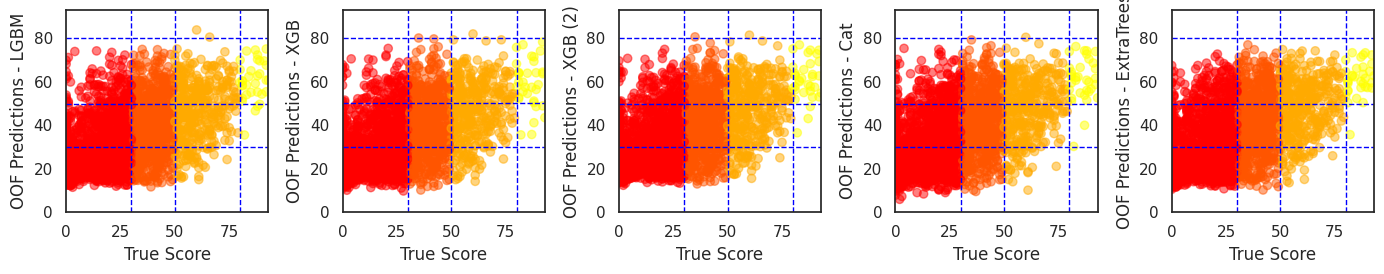

Coefs 'Meta Model': [ 0.07802449  0.43019479 -0.11387576  0.13721636  0.25425573]


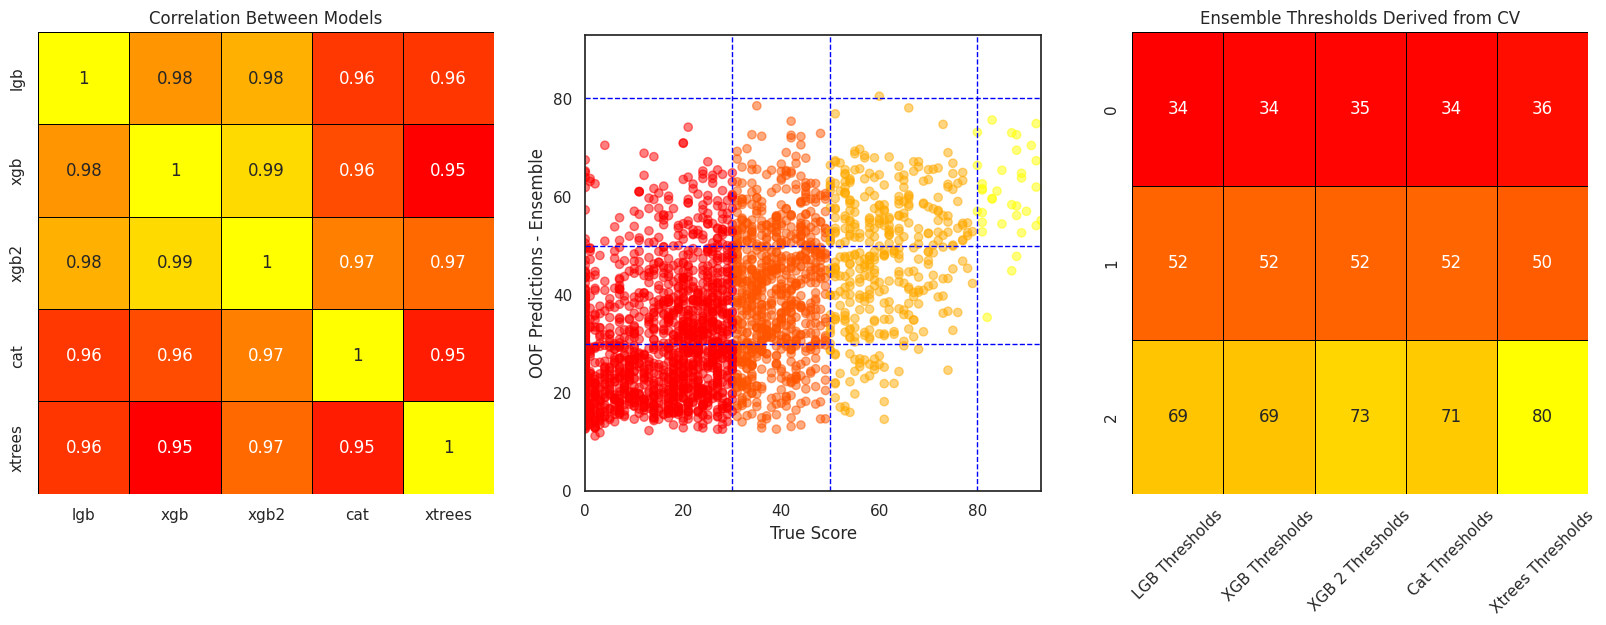

In [24]:
# Plot predicted scores against true scores with the base thresholds for converting score to sii
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 5, figsize=(14, 6))

scatter1 = axes[0].scatter(train['PCIAT-PCIAT_Total'], oof_lgb, c=train["sii"], cmap="autumn", alpha=0.5)
axes[0].set_xlabel("True Score")
axes[0].set_ylabel("OOF Predictions - LGBM")
axes[0].set_ylim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[0].set_xlim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[0].set_aspect('equal', adjustable='box')

thresholds = [30, 50, 80]
for threshold in thresholds:
    axes[0].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[0].axvline(threshold, color="blue", linestyle="--", lw=1)

scatter2 = axes[1].scatter(train['PCIAT-PCIAT_Total'], oof_xgb, c=train["sii"], cmap="autumn", alpha=0.5)
axes[1].set_xlabel("True Score")
axes[1].set_ylabel("OOF Predictions - XGB")
axes[1].set_ylim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[1].set_xlim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[1].set_aspect('equal', adjustable='box')

for threshold in thresholds:
    axes[1].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[1].axvline(threshold, color="blue", linestyle="--", lw=1)

scatter2 = axes[2].scatter(train['PCIAT-PCIAT_Total'], oof_xgb_2, c=train["sii"], cmap="autumn", alpha=0.5)
axes[2].set_xlabel("True Score")
axes[2].set_ylabel("OOF Predictions - XGB (2)")
axes[2].set_ylim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[2].set_xlim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[2].set_aspect('equal', adjustable='box')

for threshold in thresholds:
    axes[2].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[2].axvline(threshold, color="blue", linestyle="--", lw=1)
    
scatter3 = axes[3].scatter(train['PCIAT-PCIAT_Total'], oof_cat, c=train["sii"], cmap="autumn", alpha=0.5)
axes[3].set_xlabel("True Score")
axes[3].set_ylabel("OOF Predictions - Cat")
axes[3].set_ylim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[3].set_xlim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[3].set_aspect('equal', adjustable='box')

for threshold in thresholds:
    axes[3].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[3].axvline(threshold, color="blue", linestyle="--", lw=1)
    
scatter3 = axes[4].scatter(train['PCIAT-PCIAT_Total'], oof_xtrees, c=train["sii"], cmap="autumn", alpha=0.5)
axes[4].set_xlabel("True Score")
axes[4].set_ylabel("OOF Predictions - ExtraTrees")
axes[4].set_ylim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[4].set_xlim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[4].set_aspect('equal', adjustable='box')

for threshold in thresholds:
    axes[4].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[4].axvline(threshold, color="blue", linestyle="--", lw=1)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1,3, figsize=(20,6))

model_preds = pd.DataFrame({
    'lgb': oof_lgb,
    'xgb': oof_xgb,
    'xgb2': oof_xgb_2,
    'cat': oof_cat,
    'xtrees': oof_xtrees
})
corr_df = model_preds.corr()
sns.heatmap(corr_df, annot=True, cmap="autumn", cbar=False, linewidths=0.5, linecolor='black', ax=axes[0])
axes[0].set_title("Correlation Between Models")

axes[1].scatter(
    train['PCIAT-PCIAT_Total'], np.average(model_preds, axis=1, weights=[0.2, 0.2, 0.3, 0.1, 0.2]), c=train["sii"], cmap="autumn", alpha=0.5
)
axes[1].set_xlabel("True Score")
axes[1].set_ylabel("OOF Predictions - Ensemble")
axes[1].set_ylim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[1].set_xlim(0,np.max(train['PCIAT-PCIAT_Total']))
axes[1].set_aspect('equal', adjustable='box')
for threshold in thresholds:
    axes[1].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[1].axvline(threshold, color="blue", linestyle="--", lw=1)


meta_model = LinearRegression(fit_intercept = False)
meta_model.fit(model_preds, train['PCIAT-PCIAT_Total'])
meta_model.coef_
print(f"Coefs 'Meta Model': {meta_model.coef_}")

lgb_thresholds_ens = np.mean(np.array(lgb_thresholds), axis=0)
xgb_thresholds_ens = np.mean(np.array(xgb_thresholds), axis=0)
xgb_2_thresholds_ens = np.mean(np.array(xgb_2_thresholds), axis=0)
cat_thresholds_ens = np.mean(np.array(cat_thresholds), axis=0)
xtrees_thresholds_ens = np.mean(np.array(xtrees_thresholds), axis=0)

thresholds_df = pd.DataFrame({
    "LGB Thresholds": lgb_thresholds_ens,
    "XGB Thresholds": xgb_thresholds_ens,
    "XGB 2 Thresholds": xgb_2_thresholds_ens,
    "Cat Thresholds": cat_thresholds_ens,
    "Xtrees Thresholds": xtrees_thresholds_ens
})

sns.heatmap(thresholds_df, annot=True, cmap="autumn", cbar=False, linewidths=0.5, linecolor='black', ax=axes[2])
axes[2].set_title("Ensemble Thresholds Derived from CV")
axes[2].set_xticklabels(thresholds_df.columns, rotation=45)  
plt.show()

100%|██████████| 100/100 [00:00<00:00, 338.77it/s]


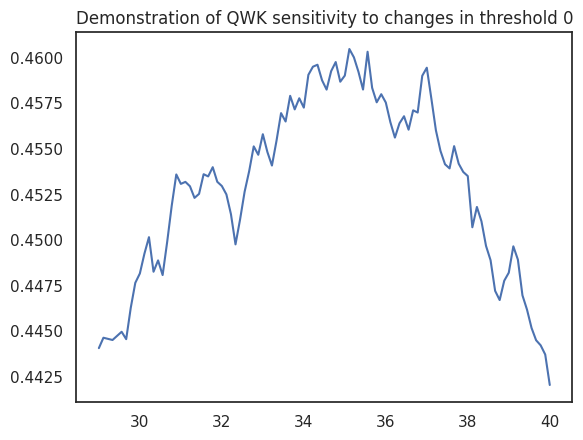

In [25]:
# Showing how sensitive QWK is with changes in threshold
scores = []
ts = []
m = 30
for i in tqdm(np.linspace(-1,10, 100)):
    thresholds = [m+i, 50, 80]
    pred = round_with_thresholds(oof_xgb, thresholds)
    score = cohen_kappa_score(train["sii"], pred, weights='quadratic')
    ts.append(m+i)
    scores.append(score)
    
plt.plot(ts, scores)
plt.title("Demonstration of QWK sensitivity to changes in threshold 0")
plt.show()

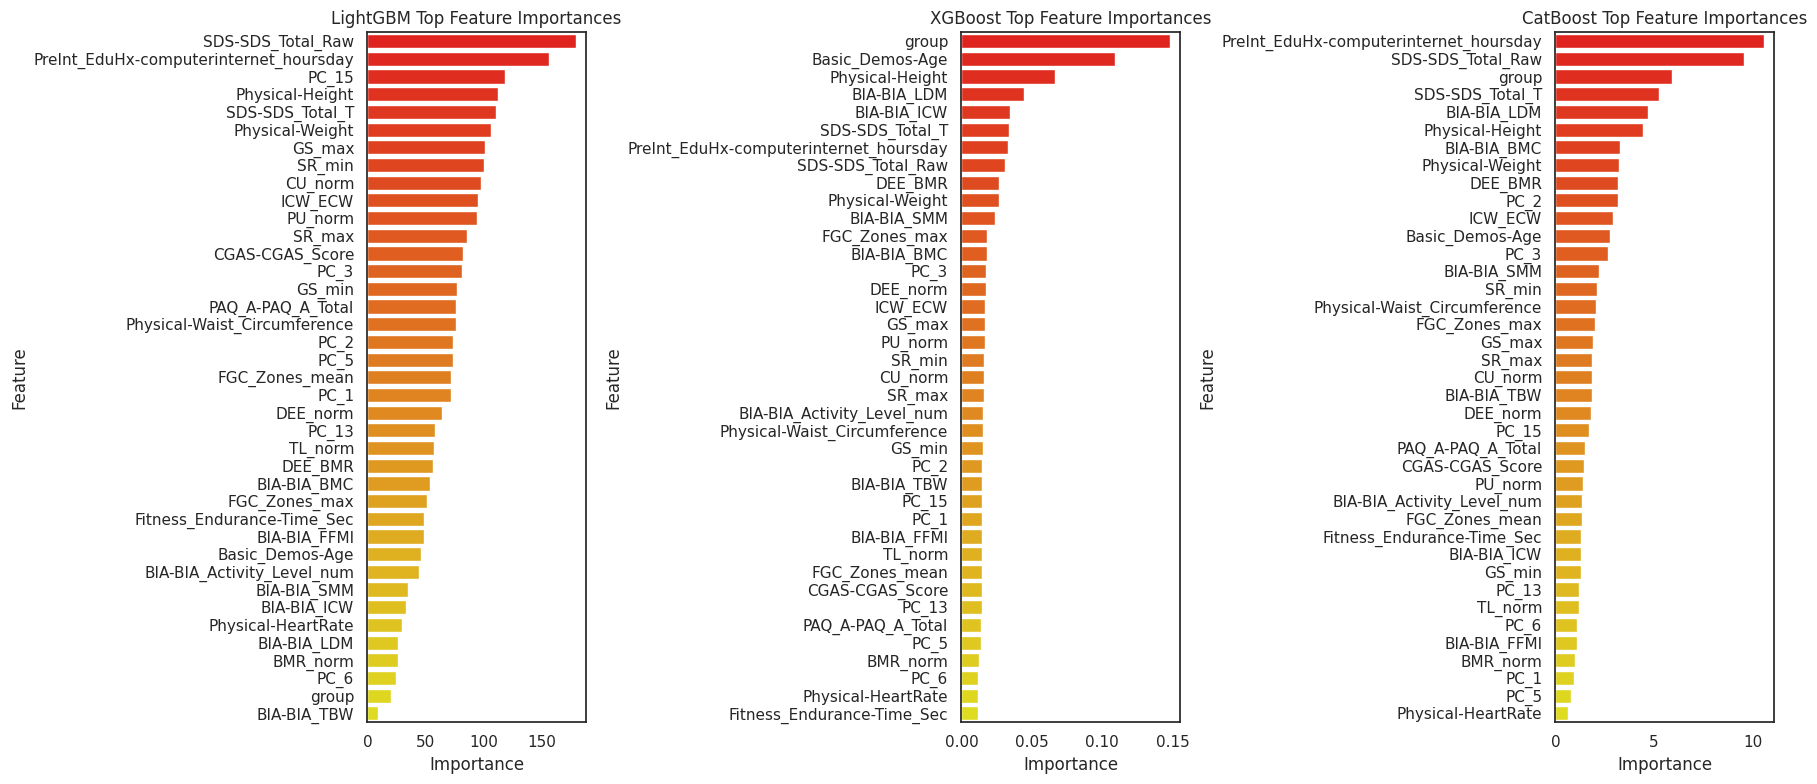

In [26]:
lgb_importances = pd.DataFrame({
    'Feature': lgb_features,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xgb_importances = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

cat_importances = pd.DataFrame({
    'Feature': cat_features,
    'Importance': cat_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Set the number of features to display
n_top_features = 40

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
sns.set_theme(style="whitegrid")

sns.barplot(ax=axes[0], data=lgb_importances.head(n_top_features),
            x='Importance', y='Feature', palette="autumn")
axes[0].set_title('LightGBM Top Feature Importances')

sns.barplot(ax=axes[1], data=xgb_importances.head(n_top_features),
            x='Importance', y='Feature', palette="autumn")
axes[1].set_title('XGBoost Top Feature Importances')

sns.barplot(ax=axes[2], data=cat_importances.head(n_top_features),
            x='Importance', y='Feature', palette="autumn")
axes[2].set_title('CatBoost Top Feature Importances')

plt.tight_layout()
plt.show()

In [27]:
(set(lgb_importances[-10:]["Feature"]) & set(xgb_importances[-10:]["Feature"]) & set(cat_importances[-10:]["Feature"]))

{'BMR_norm', 'PC_6', 'Physical-HeartRate'}

LGBM optimized Kappa: 0.4624970912020049
XGB optimized Kappa: 0.4655556130635061
XGB2 optimized Kappa: 0.46860958300088196
CAT optimized Kappa: 0.45079455779632127
ExtraTrees optimized Kappa: 0.4463848468268956
Ensemble Kappa score: 0.4742031676874453


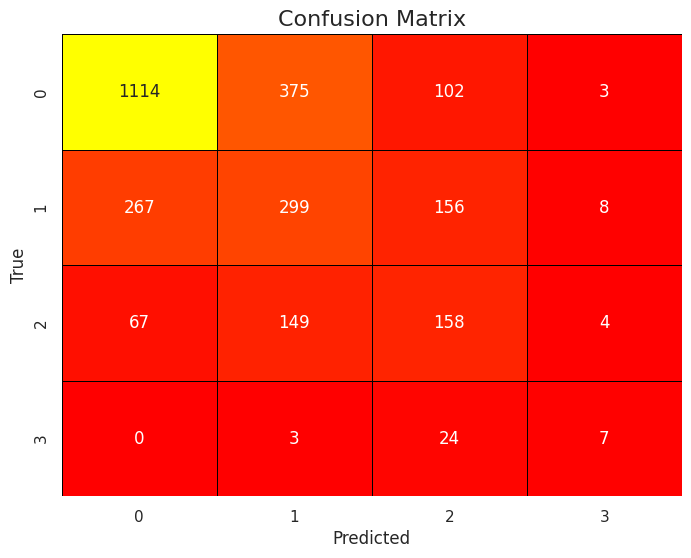

In [28]:
# Apply the optimized thresholds to OOF predictions
oof_lgb = round_with_thresholds(oof_lgb, lgb_thresholds_ens)
print(f"LGBM optimized Kappa: {cohen_kappa_score(train['sii'], oof_lgb, weights='quadratic')}")
oof_xgb = round_with_thresholds(oof_xgb, xgb_thresholds_ens)
print(f"XGB optimized Kappa: {cohen_kappa_score(train['sii'], oof_xgb, weights='quadratic')}")
oof_xgb_2 = round_with_thresholds(oof_xgb_2, xgb_2_thresholds_ens)
print(f"XGB2 optimized Kappa: {cohen_kappa_score(train['sii'], oof_xgb_2, weights='quadratic')}")
oof_cat = round_with_thresholds(oof_cat, cat_thresholds_ens)
print(f"CAT optimized Kappa: {cohen_kappa_score(train['sii'], oof_cat, weights='quadratic')}")
oof_xtrees = round_with_thresholds(oof_xtrees, xtrees_thresholds_ens)
print(f"ExtraTrees optimized Kappa: {cohen_kappa_score(train['sii'], oof_xtrees, weights='quadratic')}")

if voting:
    oof_preds = np.array([oof_lgb, oof_xgb, oof_xgb_2, oof_cat, oof_xtrees])
    voted_oof = stats.mode(oof_preds, axis=0).mode.flatten().astype(int)
    final_oof = voted_oof
else: 
    weights = [0.2, 0.2, 0.3, 0.1, 0.2]
    oof_preds = np.array([oof_lgb, oof_xgb, oof_xgb_2, oof_cat, oof_xtrees])
    weighted_oof = np.average(oof_preds, axis=0, weights=weights)
    final_oof = np.round(weighted_oof).astype(int)

pd.DataFrame(final_oof).to_csv("oof_mv41.csv")
# Calculate Kappa score for voted OOF predictions
kappa_score = cohen_kappa_score(train["sii"], final_oof, weights='quadratic')
print(f"Ensemble Kappa score: {kappa_score}")
# Plot confusion matrix
conf_matrix = confusion_matrix(train["sii"], final_oof)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="autumn", cbar=False, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()